Based on "A Neural Probabilistic Language Model" by Bengio et al. (2003)

This is the improved version of the neural language model from the previous notebook.

In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
with open('data/names.txt', 'r') as f:
    words = [word.strip().lower() + '.' for word in f.readlines()]

train, valid, test = 0.8, 0.1, 0.1
train_words = words[:int(len(words) * train)]
valid_words = words[int(len(words) * train):int(len(words) * (train + valid))]
test_words = words[int(len(words) * (train + valid)):]

print(f'Average word length in training set: {sum([len(word) for word in train_words]) / len(train_words)}')

Average word length in training set: 7.132521657691407


In [3]:
class WordDataSet(Dataset):
    def __init__(self, words, blck_size):
        self.words = words
        self.blck_size = blck_size

        # Create a dictionary that maps char to integers, and vice versa
        self.chars = sorted(list(set(''.join(self.words))))
        self.char_to_int = {c: i + 1 for i, c in enumerate(self.chars)}
        self.char_to_int['.'] = 0
        self.int_to_char = {i: c for c, i in self.char_to_int.items()}

        X, y = [], []
        for w in self.words:
            context = [0] * blck_size
            for i in range(len(w)):
                idx = self.char_to_int[w[i]]
                X.append(context)
                y.append(idx)
                context = context[1:] + [idx]

        self.X = torch.tensor(X)
        self.y = torch.tensor(y)

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]    

In [90]:
blck_size = 6
train_ds = WordDataSet(train_words, blck_size)
valid_ds = WordDataSet(valid_words, blck_size)
test_ds = WordDataSet(test_words, blck_size)

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=64, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=True)

In [119]:
class NNLM(torch.nn.Module):
    # Neural Network Language Model
    def __init__(self, emb_size, hidden_size, vocab_size, blck_size):
        super(NNLM, self).__init__()
        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.blck_size = blck_size

        self.emb = torch.nn.Parameter(torch.randn(vocab_size, emb_size))
        # fixing initial loss: multiply W1 by 0.1, we don't want to have large logits at initialization

        # manual tuning initialization (not optimal)
        # self.W1 = torch.nn.Parameter(torch.randn(emb_size * blck_size, hidden_size) * 0.1)

        # Kaiming initialization
        self.W1 = torch.nn.Parameter(torch.nn.init.kaiming_normal_(torch.empty(emb_size * blck_size, hidden_size), nonlinearity='tanh'))
        
        # adding bias here is redundant, because we have batch normalization
        # fixing saturated tanh: set b1 close to 0, get a little bit of entropy
        # self.b1 = torch.nn.Parameter(torch.randn(hidden_size) * 0.01)

        # fixing initial loss: multiply W2 by 0.01, we don't want to have large logits at initialization
        self.W2 = torch.nn.Parameter(torch.randn(hidden_size, vocab_size) * 0.01)

        # fixing initial loss: set b2 to 0, we don't want bias at initialization
        self.b2 = torch.nn.Parameter(torch.zeros(vocab_size))

        self.bn_gain = torch.nn.Parameter(torch.ones(hidden_size))
        self.bn_bias = torch.nn.Parameter(torch.zeros(hidden_size))

    def forward(self, x, return_hidden=False):
        x = self.emb[x]
        x = x.view(-1, self.emb_size * self.blck_size)
        hidden = torch.matmul(x, self.W1)
        # batch normalization
        hidden = (hidden - hidden.mean(dim=1, keepdim=True)) / (hidden.std(dim=1, keepdim=True) + 1e-5)
        hidden = hidden * self.bn_gain + self.bn_bias
        x = torch.tanh(hidden)
        x = torch.matmul(x, self.W2) + self.b2
        if return_hidden:
            return x, hidden
        else:
            return x

* Embedding size > 32 doesn't make sense, because the alphabet size is only 26.
* The block size is set to 6. It doesn't make sense to set it to be > 7, which is the average word length in the training set.

In [120]:
model = NNLM(8, 128, len(train_ds.chars) + 1, blck_size)
model.to(device)
print(f'Number of parameters: {sum([p.numel() for p in model.parameters()])}')

num_epochs = 100
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loss, valid_loss = [], []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for x, y in train_dl:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_hat = model(x)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss.append(running_loss / len(train_dl))

    model.eval()
    running_loss = 0
    for x, y in valid_dl:
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)
        running_loss += loss.item()
    valid_loss.append(running_loss / len(valid_dl))

    print(f'Epoch: {epoch + 1}/{num_epochs} | Train loss: {train_loss[-1]:.4f} | Valid loss: {valid_loss[-1]:.4f}')

Number of parameters: 10236
Epoch: 1/100 | Train loss: 2.3025 | Valid loss: 2.4019
Epoch: 2/100 | Train loss: 2.1612 | Valid loss: 2.3639
Epoch: 3/100 | Train loss: 2.1178 | Valid loss: 2.3449
Epoch: 4/100 | Train loss: 2.0906 | Valid loss: 2.3399
Epoch: 5/100 | Train loss: 2.0717 | Valid loss: 2.3253
Epoch: 6/100 | Train loss: 2.0579 | Valid loss: 2.3281
Epoch: 7/100 | Train loss: 2.0459 | Valid loss: 2.3034
Epoch: 8/100 | Train loss: 2.0373 | Valid loss: 2.3115
Epoch: 9/100 | Train loss: 2.0295 | Valid loss: 2.3096
Epoch: 10/100 | Train loss: 2.0227 | Valid loss: 2.2892
Epoch: 11/100 | Train loss: 2.0174 | Valid loss: 2.3018
Epoch: 12/100 | Train loss: 2.0128 | Valid loss: 2.3033
Epoch: 13/100 | Train loss: 2.0095 | Valid loss: 2.2992
Epoch: 14/100 | Train loss: 2.0053 | Valid loss: 2.2965
Epoch: 15/100 | Train loss: 2.0020 | Valid loss: 2.2968
Epoch: 16/100 | Train loss: 1.9984 | Valid loss: 2.3043
Epoch: 17/100 | Train loss: 1.9963 | Valid loss: 2.2983
Epoch: 18/100 | Train loss: 1

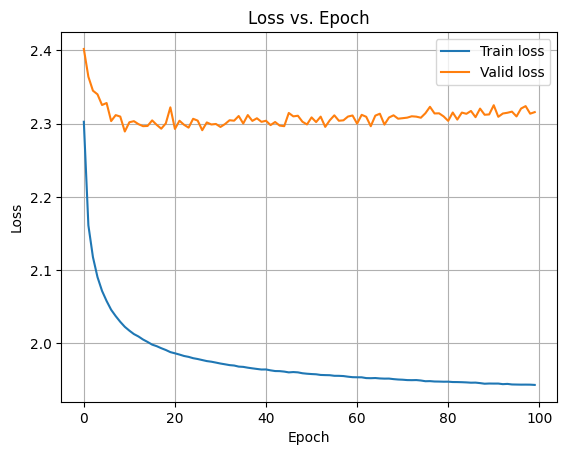

In [121]:
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.grid()
plt.show()

In [96]:
def visualize_activated_neurons(model, input_batch, int_to_char, blck_size, threshold=0.99):
    # Pass the input batch through the model and get the hidden layer output
    _, hidden_batch = model(input_batch, return_hidden=True)

    # Calculate activated neurons
    tanh_hidden_batch = torch.tanh(hidden_batch)
    activated_neurons_batch = (tanh_hidden_batch.abs() > threshold).float()
    print(f'% of activated neurons: {activated_neurons_batch.mean() * 100:.2f}%')

    # Plot the activated neurons for each sample
    plt.figure(figsize=(10, 5))
    plt.imshow(activated_neurons_batch, cmap='gray', aspect='auto', interpolation='nearest')
    plt.xlabel("Neuron index")
    plt.ylabel("Sample index")
    plt.title("Activated neurons in the hidden layer")
    plt.colorbar()
    plt.show()    

% of activated neurons: 51.89%


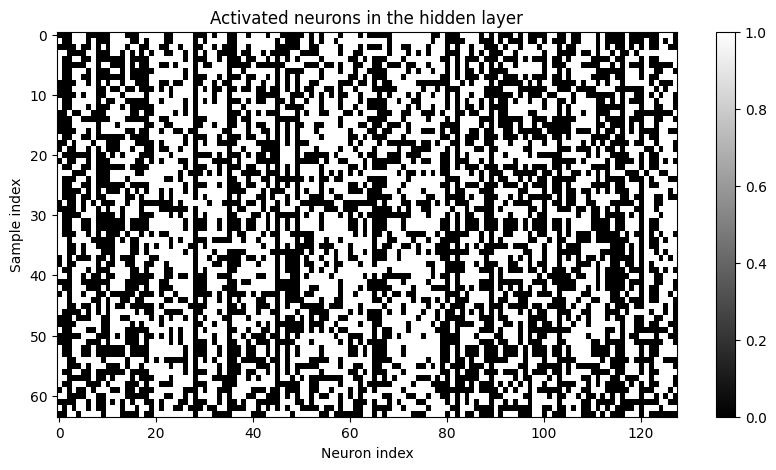

In [135]:
# Get a batch from the train_loader
input_batch, _ = next(iter(train_dl))

# Call the visualization function
visualize_activated_neurons(model, input_batch, train_ds.int_to_char, blck_size)

The above image shows that the hidden layer neurons are working as expected: there are no samples in which all the neurons are active or inactive. This means that no hidden layer neurons are redundant. There are also diverse patterns of neuron activations, which means that the hidden layer is learning different features.

In [89]:
# sampling
max_length = 20
num_words = 10

model.eval()
for _ in range(num_words):
    context = [0] * blck_size
    generated_word = []
    for _ in range(max_length):
        x = torch.tensor([context])
        y_hat = model(x)
        # output has shape (1, vocab_size), squeeze to (vocab_size)
        probs = F.softmax(y_hat, dim=1).squeeze()
        sampled_char_idx = torch.multinomial(probs, 1).item()
        if sampled_char_idx == 0:
            break
        generated_word.append(train_ds.int_to_char[sampled_char_idx])
        context = context[1:] + [sampled_char_idx]
    print(''.join(generated_word))

alysha
zirphan
harlon
ivi
yuni
harmoney
laven
kinzia
taylynn
macherisza
